### Instituto Tecnológico de Costa Rica (ITCR)
### Escuela de Computación
### Curso: Inteligencia Artificial
 
### Cuarta tarea programada 2022-I

Profesora: María Auxiliadora Mora


# Estudiantes
Roy Chavarría Garita - 2018034199 \
Jonder Hernández Gutiérrez - 2018203660

# Sección 1. Clustering 

In [20]:
# Para el xls de pandas
!pip install --upgrade xlrd
!pip install pyspark
!pip install quinn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
# Bibliotecas
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import torch
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Me ayudará con excel
import xlrd

# Para la limpieza de los datos usando spark
from pyspark.context import SparkContext
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.types import *

# Estos sirven para quitar espacios en blanco de las palabras
from pyspark.sql.functions import ltrim,rtrim,trim
from pyspark.sql.functions import length,col
import pyspark.sql.functions as F
import quinn

from pyspark.sql import SparkSession, Row, dataframe
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext.getOrCreate();
#sc = SparkContext('local')
spark = SparkSession(sc)


## Algoritmo K-means

In [22]:
def eucledian_distance(centroid, row):
  """
  Calcula la distancia euclediana sin importar las dimensiones
  Entrada: 2 listas o tensores de datos una representa al centroide y la otra representa un punto 
  Salida: un numero representando la distancia
  """
  #Tomo el largo de la lista row, las 2 listas (centroid, row) siempre va a tener el mismo largo
  dimension = len(row)

  #Variable para almacenar la suma de las diferencias al cuadrado
  distance = 0

  #por cada valor en la lista, calculo la diferencia al cuadrado y la sumo
  for i in range(0, dimension):
    distance += ((centroid[i]-row[i])**2)
  
  #Retorno la raiz de la suma de las diferencias al cuadrado de todos los puntos en la lista
  return distance**(1/2)

In [23]:
def k_means(X, k):

  #Extraigo la lista de datos y la guardo en X
  #X = data.values

  """
  Algoritmo kmeans
  Entrada: Un conjunto de datos X en formato tensor, numero de clusters k
  Salida:  2 listas una repreentando los centroides y otra representando los clusters
  """

  # Bandera para el ciclo while
  diff = 1

  # Una lista de n ceros donde n es la cantidad de filas del conjunto de datos 
  cantRows = len(X)
  cluster = np.zeros(cantRows)
  
  # Una lista con k centroides que va a ir siendo ajustados (aleatoriamente)
  #centroids = np.random.choice(X, k)
  centroids = random.choices(X, k=k)
  #centroids = data.sample(n=k).values
  while diff:
     
     # Por cada fila (i, row) -> i va aumentando en 1
     for i, row in enumerate(X):
       
       # Establezco una variable (minimaDistancia) con un número muy grande al principio
       min_dist = float('inf')
       # Por cada punto saco la distancia al centroide
       for idx, centroid in enumerate(centroids):
         
         # Calculo la distancia utilizando la distancia euclediana
         d = eucledian_distance(centroid, row)

         # Verifico si la nueva distancia es menor a la actual
         if min_dist > d:
           # Establesco la mejor distancia
           min_dist = d
           # Establesco el cluster al que mejor pertenece (por orden de lista)
           cluster[i] = idx
     
     # Guardo y ordeno los datos dependiendo del cluster
     new_centroids = pd.DataFrame(X).groupby(by=cluster).mean().values
     #new_centroids = torch.tensor(new_centroids)
     
     # si los centroides son iguales, dentengo el ciclo
     # También se puede establecer un punto de parada por número de iteraciones

     centroids = [x.tolist() for x in centroids]

     if np.count_nonzero(centroids-new_centroids) == 0:
       diff = 0
     else:
       centroids = new_centroids

  centroids = np.array(centroids)
  return centroids, cluster

## Datos algoritmo K-Means, prueba y visualización

Se generan datos

In [24]:
# Genero una lista de datos aleatorios (0-100) una matriz de 300 filas y 2 columnas
X = torch.randint(100, (300, 2))
#Genero 4 clusters
K = 4

Se grafican los datos generados

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


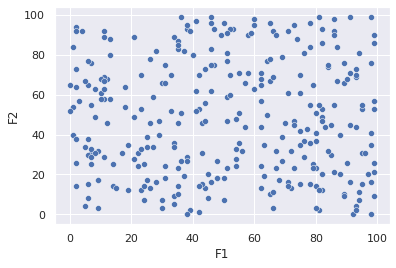

In [25]:
# Gráfico en 2 dimensiones para representar distribución de los puntos
sns.scatterplot(X[:,0], X[:, 1])
plt.xlabel('F1')
plt.ylabel('F2')
plt.show()

Aplico el algoritmo de K-Means

In [26]:
# Comienzo a aplicar el algoritmo k-means al conjunto de datos artificial
centroids, cluster = k_means(X, K)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


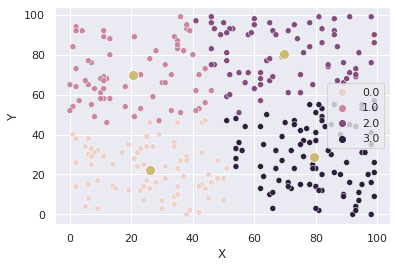

In [27]:

# Muestro f¿gráficamente el resultado 

sns.scatterplot(X[ : , 0], X[ : , 1], hue=cluster)
sns.scatterplot(centroids[:,0], centroids[:, 1], s=100, color='y')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Algoritmo DBSCAN

In [28]:
#Implementación de DBSCAN
from itertools import cycle, islice

class CustomDBSCAN():
    def __init__(self):
        self.core = -1
        self.border = -2

    # Find all neighbour points at epsilon distance
    def neighbour_points(self, data, pointId, epsilon):
        points = []
        for i in range(len(data)):
            # Euclidian distance
            if np.linalg.norm([a_i - b_i for a_i, b_i in zip(data[i], data[pointId])]) <= epsilon:
                points.append(i)
        return points

    # Fit the data into the DBSCAN model
    def fit(self, data, Eps, MinPt):
        # initialize all points as outliers
        point_label = [0] * len(data)
        point_count = []

        # initilize list for core/border points
        core = []
        border = []

        # Find the neighbours of each individual point
        for i in range(len(data)):
            point_count.append(self.neighbour_points(data, i, Eps))

        # Find all the core points, border points and outliers
        for i in range(len(point_count)):
            if (len(point_count[i]) >= MinPt):
                point_label[i] = self.core
                core.append(i)
            else:
                border.append(i)

        for i in border:
            for j in point_count[i]:
                if j in core:
                    point_label[i] = self.border
                    break

        # Assign points to a cluster

        cluster = 1

        # Here we use a queue to find all the neighbourhood points of a core point and find the indirectly reachable points
        # We are essentially performing Breadth First search of all points which are within Epsilon distance for each other
        for i in range(len(point_label)):
            q = []
            if (point_label[i] == self.core):
                point_label[i] = cluster
                for x in point_count[i]:
                    if(point_label[x] == self.core):
                        q.append(x)
                        point_label[x] = cluster
                    elif(point_label[x] == self.border):
                        point_label[x] = cluster
                while (len(q)>0):
                    neighbors = point_count[q[0]]
                    q=q[1:]
                    for y in neighbors:
                        if (point_label[y] == self.core):
                            point_label[y] = cluster
                            q.append(y)
                        if (point_label[y] == self.border):
                            point_label[y] = cluster
                cluster += 1  # Move on to the next cluster

        return point_label, cluster

    # Visualize the clusters
    def visualize(self, data, cluster, numberOfClusters):
        N = len(data)
        colors2 = ['black','red', 'blue', 'green']

        colors = np.array(list(islice(cycle(['#FE4A49', '#2AB7CA', '#2aca3a']), 3)))
        #print(colors)

        for i in range(numberOfClusters):
            if (i == 0):
                # Plot all outliers point as black
                color = '#000000'
            else:
                color = colors[i % len(colors)]

            x, y = [], []
            for j in range(N):
                if cluster[j] == i:
                    x.append(data[j][0])
                    y.append(data[j][1])
            label = f'Cluster {i}'
            if i == 0:
                label = "Puntos ruido"
            plt.scatter(x, y, c=color, alpha=1, marker='.', label=label)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), 
           ncol=2)
        plt.show()

## Datos algoritmo DBSCAN, prueba y visualización

Generamos datos para probar DBSCAN

In [29]:
#Meter dato de prueba
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
centers = [[1, 1], [-1, -1], [1, -1]]
j, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4, random_state=0)
j = StandardScaler().fit_transform(j)

Graficamos los datos generados

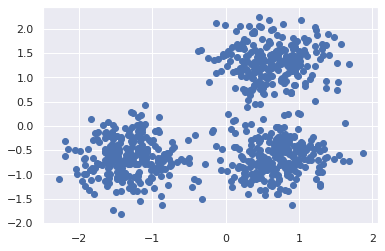

In [30]:
plt.scatter(j[:,0], j[:,1])

Calculamos DBSCAN, mostrando algunos datos de los datos y los clusters:

Datos generados escalados:
[[ 0.49426097  1.45106697]
 [-1.42808099 -0.83706377]
 [ 0.33855918  1.03875871]
 ...
 [-0.05713876 -0.90926105]
 [-1.16939407  0.03959692]
 [ 0.26322951 -0.92649949]]
Clusters de los datos (Se muestran solo 20):
[1, 2, 1, 3, 1, 2, 2, 3, 1, 1, 2, 2, 2, 3, 2, 1, 0, 2, 2, 3] ....
Cantidad de Clusters:
4


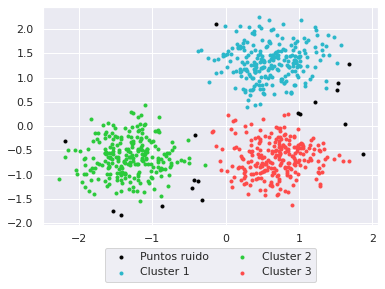

In [31]:
print("Datos generados escalados:")
print(j)

custom_DBSCAN = CustomDBSCAN()
point_labels, clusters = custom_DBSCAN.fit(j, 0.30, 10)

print("Clusters de los datos (Se muestran solo 20):")
print(point_labels[:20],"....")

print("Cantidad de Clusters:")
print(clusters)

custom_DBSCAN.visualize(j, point_labels, clusters)

## Preprocesamiento de los datos del oij y censo con spark



## Leemos los archivos del censo y del oij 

In [19]:
#Con skiprow le indico que me lea de la fila numero 4 en adelante 
#y con usecols le indico el rango de columnas de mi interés, todo esto solo para los datos del censo
xls_censo = pd.read_excel('datos_censo.xlsx', skiprows = 9, usecols=range(1,8))

#Limpio el xls_censo quitandole las filas que están en blanco
xls_censo = xls_censo.dropna()

#Esto me cambia el nombre de las columnas de los datos del censo
xls_censo.rename(columns={'Unnamed: 1':'provinciaCantonYDistrito',
                          'Unnamed: 2':'población_de_15_años_y_más',
                          'Unnamed: 3':'tasa_neta_de_participación',
                          'Unnamed: 4':'tasa_de_ocupación',
                          'Unnamed: 5':'tasa_de_desempleo_abierto',
                          'Unnamed: 6':'porcentaje_de_población_económicamente_inactiva',
                          'Unnamed: 7':'relación_de_dependencia_económica'},inplace=True)


#Leemos los datos del oij
xls_oij = pd.read_excel('datos_oij.xlsx')


#Creamos los dataframe del oij y del censo
dfPandas_censo = pd.DataFrame(xls_censo)
dfPandas_oij = pd.DataFrame(xls_oij)

#print(dfPandas_censo)
#print(dfPandas_oij)
#Defino el tipo de datos, que va a tener el datafame_censo de spark, porque si no me da error al crear el frame en spark
mySchema = StructType([ StructField("provinciaCantonYDistrito", StringType(), True)\
                       ,StructField("población_de_15_años_y_más", FloatType(), True)\
                       ,StructField("tasa_neta_de_participación", FloatType(), True)\
                       ,StructField("tasa_de_ocupación", FloatType(), True)\
                       ,StructField("tasa_de_desempleo_abierto", StringType(), True)\
                       ,StructField("porcentaje_de_población_económicamente_inactiva", FloatType(), True)\
                       ,StructField("relación_de_dependencia_económica", FloatType(), True)])

# Creamos el spark dataframe
df_censo = spark.createDataFrame(dfPandas_censo, schema=mySchema)
df_oij = spark.createDataFrame(dfPandas_oij)

#df_censo.show()

print("Terminado correctamente")

Terminado correctamente


## Función que elimine los espacios en blanco de la columna distrito para usarse en ambos conjuntos de datos.

In [32]:
#ESta funcion muestra el antes y el despues de aplicar la funcion de quitar los espacios dentro del censo

# Descripción Muestra el largo de del contenido de una columna de un dataframe
# Entrada: 
#   df: Dataframe a modificar la columna
#   colum: nombre de la columna a modificar
#   alias: alias de la columna nueva a mostrar
#   cant: cantidad de elementos a mostrar y contar su contenido
def mostrar_largo_celdas(df, colum, alias, cant):
    df.select(length(col(colum)).alias(alias)).show(cant)

    

#Verifico que tengan los espacios en blanco
#mostrar_largo_celdas(df_censo, "provinciaCantonYDistrito", "length_with_whitespace_censo", 5)
#mostrar_largo_celdas(df_oij, "Distrito", "length_with_whitespace_oij", 5)


# Descripción Elimina los espacios en blanco de una columna de un dataframe
# Entradas:
#   df: Dataframe a modificar la columna
#   colum: nombre de la columna a modificar
# Salida: El dataframe con la columna modificada
def eliminar_espacios_en_blanco(df, colum):
    df = df.withColumn(colum,quinn.remove_all_whitespace(col(colum)))
    return df

#Elimino los espacios    
df_censo = eliminar_espacios_en_blanco(df_censo, "provinciaCantonYDistrito")
df_oij = eliminar_espacios_en_blanco(df_oij, "Distrito")


#Verifico que se eliminaron los espacios en blanco en las dos columnas(censo y oij) correctamente

#mostrar_largo_celdas(df_censo, "provinciaCantonYDistrito", "length_without_whitespace_censo", 5)
#mostrar_largo_celdas(df_oij, "Distrito", "length_without_whitespace_oij", 5)
                  
    
#df_censo.show(10)
print("Espacios en blanco eliminados correctamente")

Espacios en blanco eliminados correctamente


## Una función que convierta a minúsculas el contenido de la columna distrito para usarse en ambos conjuntos de datos.

In [33]:
# Descripción: Muestra los datos de una columna en un dataframe
# Entradas:
#   df: Dataframe a mostrar
#   colum: nombre de la columna a mostrar
#   alias: Alias de la columna del resultado
#   cant: cantidad de elementos a mostrar
def mostrar_datos_celdas(df, colum, alias, cant):
    df.select(col(colum)).alias(alias).show(cant)
    
#Verifico que algunos datos estén con mayusculas
#mostrar_datos_celdas(df_censo, "provinciaCantonYDistrito", "Dates_with_upperCase_censo", 5)
#mostrar_datos_celdas(df_oij, "Distrito", "Dates_with_upperCase_oij", 5)

# Descripción: Convierte los datos de una columna en un dataframe a minuscula
# Entradas:
#   df: Dataframe a modificar la columna
#   colum: nombre de la columna a modificar
# Salida: El dataframe con la columna modificada
def convertir_celda_a_minuscula(df, colum):
    df = df.withColumn(colum,lower(col(colum)))
    return df
# Convierto a minisculas las columnas "provinciaCantonYDistrito" y "Distrito" de los datos del OIJ y del INEC respectivamente
df_censo = convertir_celda_a_minuscula(df_censo, "provinciaCantonYDistrito")
df_oij = convertir_celda_a_minuscula(df_oij, "Distrito")

# Muestro los datos para verificar que se realizó el cambio correctamente
#mostrar_datos_celdas(df_censo, "provinciaCantonYDistrito", "Dates_without_upperCase_censo", 5)
#mostrar_datos_celdas(df_oij, "Distrito", "Dates_without_upperCase_oij", 5)

print("Palabras convertidas a minúsculas")

Palabras convertidas a minúsculas


## Elimino acentos o tíldes

In [34]:
# Descripción: Quito los acentos y 'ñ' de los datos de una columna en un dataframe
# Entrada:
#   df: Dataframe a modificar la columna
#   colum: nombre de la columna a modificar
# Salida: El dataframe con la columna modificada
def quitar_acentos(df, nombre_columna):
    df= df.withColumn(nombre_columna, regexp_replace(nombre_columna, "á", "a"))
    df= df.withColumn(nombre_columna, regexp_replace(nombre_columna, "é", "e"))
    df= df.withColumn(nombre_columna, regexp_replace(nombre_columna, "í", "i"))
    df= df.withColumn(nombre_columna, regexp_replace(nombre_columna, "ó", "o"))
    df= df.withColumn(nombre_columna, regexp_replace(nombre_columna, "ú", "u"))
    df= df.withColumn(nombre_columna, regexp_replace(nombre_columna, "ñ", "n"))
    return df

#Quito acentos y ñs de los datos del oij para que los datos calzen
df_censo = quitar_acentos(df_censo, "provinciaCantonYDistrito")
#df_oij = quitar_acentos(df_oij, "Distrito")



#df_censo.toPandas().to_csv('df_censo.csv')
#df_oij.toPandas().to_csv('df_oij.csv')
print("Tíldes eliminadas correctamente")

Tíldes eliminadas correctamente


## Junto los datos del oij y el inec con 

In [35]:
#Junto los datos del censo con los del oij
df_censo_join_oij = df_censo.join(df_oij,df_censo.provinciaCantonYDistrito ==  df_oij.Distrito,"inner")
df_censo_join_oij.count()

#Mara mostrar los datos
df_censo_join_oij.show()


+------------------------+--------------------------+--------------------------+-----------------+-------------------------+-----------------------------------------------+---------------------------------+------+--------------------+-------------------+-------------------+-----------+--------------------+-------------+-----------+------------+---------+-------+----------+
|provinciaCantonYDistrito|población_de_15_años_y_más|tasa_neta_de_participación|tasa_de_ocupación|tasa_de_desempleo_abierto|porcentaje_de_población_económicamente_inactiva|relación_de_dependencia_económica|Delito|           SubDelito|              Fecha|               Hora|    Victima|          SubVictima|         Edad|     Genero|Nacionalidad|Provincia| Canton|  Distrito|
+------------------------+--------------------------+--------------------------+-----------------+-------------------------+-----------------------------------------------+---------------------------------+------+--------------------+--------------

## Varables a utilizar y documentación del motivo de la selección de acuerdo al problema en estudio:

1. Porcentaje de población económicamente inactiva
2. Tasa de desempleo abierto
3. Relación de dependencia económica
4. Edad
5. Cantidad de delitos por distrito.

El **Porcentaje de población económicamente inactiva** y la **tasa de desempleo abierto** nos da una idea de cuantas personas se encuentran fuera del mundo laboral y cuantas de estas personas desempleadas están interesadas en conseguir trabajo. 
La **edad** y la **relación de dependencia económica** nos puede dar una idea de las necesidades económicas de los que cometen estos delitos respecto a su edad. 

In [36]:
#df_censo_join_oij.show()
df_temp = df_censo_join_oij

#Calculo la cantidad de delitos por distrito
df_temp = df_temp.groupby('Distrito').agg(count('Provincia').alias('cantidad_delitos_por_distrito')).sort(desc("cantidad_delitos_por_distrito"))

#Extraigo las columnas que necesito para hacer el join
variables_dataframe = df_censo_join_oij.select("porcentaje_de_población_económicamente_inactiva",
                                               "tasa_de_desempleo_abierto",
                                               "relación_de_dependencia_económica",
                                               "Edad",
                                               "Distrito") # El distrito es para hacer join

#Realizo la union de datos utilizando un join y retornando una matriz con las 5 variables
new_dataframe = variables_dataframe.join(df_temp,variables_dataframe.Distrito ==  df_temp.Distrito,"inner")


#Puedo eliminar los repetidos pero pierdo información en edad
#new_dataframe = new_dataframe.dropDuplicates(['Distrito'])


# Especifico el nombre de columnas que voy a utilizar
dataframe = new_dataframe.select('porcentaje_de_población_económicamente_inactiva',
           'tasa_de_desempleo_abierto', 'relación_de_dependencia_económica',
           'Edad','cantidad_delitos_por_distrito')

#Mostramos que el proceso se haya echo correctamente
dataframe.show()

#Cuento los datos
dataframe.count()

+-----------------------------------------------+-------------------------+---------------------------------+-------------+-----------------------------+
|porcentaje_de_población_económicamente_inactiva|tasa_de_desempleo_abierto|relación_de_dependencia_económica|         Edad|cantidad_delitos_por_distrito|
+-----------------------------------------------+-------------------------+---------------------------------+-------------+-----------------------------+
|                                      54.264084|        3.700097370983447|                          2.06037|Mayor de edad|                           20|
|                                      54.264084|        3.700097370983447|                          2.06037| Adulto Mayor|                           20|
|                                      54.264084|        3.700097370983447|                          2.06037|Mayor de edad|                           20|
|                                      54.264084|        3.700097370983447| 

40252

# Prueba de datos usando k-Means

In [37]:
#Importo la biblioteca para codificar los targets
from sklearn.preprocessing import LabelEncoder

#Convertir la columna de Edad a números
#Se crea una función para codficar las etiquetas que no son números
#En el cual estaremos seleccionando las columnas que tienen valores categóricos y 
#realizaremos la codificación de etiquetas. 

def Encoder(df):
  #Recibe un dataframe de pandas
  #Retorna un dataframe de pandas con las etiquetas codificadas
  
  columnsToEncode = list(df.select_dtypes(include=['category','object']))
  le = LabelEncoder()
  for feature in columnsToEncode:
      try:
          df[feature] = le.fit_transform(df[feature])
      except:
          print('Error encoding '+feature)
  return df

In [38]:
# Convierto el dataframe de spark a pandas para usarlo en la función
dataframe = dataframe.toPandas()

In [39]:
#Se crea un objeto 'columnsToEncode' que hará una lista de columnas que tienen valores categóricos,
# es decir, las columnas que tienen el tipo de datos 'categoría' u 'objeto'.
columnsToEncode = list(dataframe.select_dtypes(include=['category','object']))

In [40]:
# Inicializo el label encoder
le = LabelEncoder()

In [41]:
"""
Ciclo que iterará sobre las columnas de la lista 'columnsToEncode'.
En el bucle, hemos utilizado la función try y except, que consta de 2 bloques, 'try' y 'except'.
 Funciona de manera que se ejecutarán las primeras declaraciones dentro del bloque de prueba y
 , si tiene algún error, solo se ejecutará el bloque de excepción.
En el bloque except hemos utilizado el método fit_transform de LabelEncoder con el atributo df[feature] y 
en el bloque except hay una declaración de impresión.
"""
for feature in columnsToEncode:
              try:
                  dataframe[feature] = le.fit_transform(dataframe[feature])
              except:
                  print('Error encoding '+feature)

In [42]:
#Por último mandamos nuestro dataframe a la función
df = Encoder(dataframe)

#Mostramos que la codificación en la columna se haya echo correctamente
#display(df)

In [43]:
#Convierto el dataframe de pandas a una matriz de numpy para usarla en el kmeans
df = df.to_numpy()

In [44]:
# Asigno los datos a una variable
X = torch.tensor(df)

#Reviso las primeras 3 filas para observar cómo son mis datos
print(X[:3])

# Nombro el número de clusters que utilizaré
K = 4

tensor([[ 54.2641, 335.0000,   2.0604,   2.0000,  20.0000],
        [ 54.2641, 335.0000,   2.0604,   0.0000,  20.0000],
        [ 54.2641, 335.0000,   2.0604,   2.0000,  20.0000]],
       dtype=torch.float64)


In [45]:
# Comienzo a aplicar el algoritmo k-means al conjunto de datos artificial
centroids, cluster = k_means(X, K)

#Método del codo para seleccionar el mejor K y vuelva a ejecutar el algoritmo usando el K recomendado.

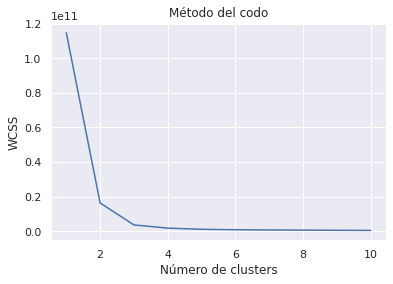

In [46]:
# Cargo la biblioteca sklearn para usar el kmeans 
from sklearn.cluster import KMeans

#Suma de los cuadrados de las distancias de cada punto de datos en todos los grupos a sus respectivos
 #centroides(WCSS).
wcss = []

for i in range(1, 11):
  # Inicializo el modelo
  kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
  #Entreno el modelo
  kmeans.fit(X)
  #Guardo el resultado de la suma de los cuadrados en una variable
  wcss.append(kmeans.inertia_)

# Grafica de la suma de las distancias
plt.plot(range(1, 11), wcss)
#Titulo
plt.title('Método del codo')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.show()

In [48]:
# Vuelvo a ejecutar el algoritmo pero ahora utilizando un k = 3

#Asigno el k
K = 3

#Vuelvo a entrenar
centroids_2, cluster_2 = k_means(X, K)

## Utilice el algoritmo DBSCAN implementado en el ejercicio 1 para caracterizar los datos usando las variables seleccionadas.

In [49]:
def check_core_point(eps,minPts, df, index):
    #get points from given index
    v, w, x, y, z, = df.iloc[index][0], df.iloc[index][1], df.iloc[index][2], df.iloc[index][3], df.iloc[index][4]
    
    #check available points within radiu
    # np.linalg.norm([a_i - b_i for a_i, b_i in zip(data[i], data[pointId])]) <= epsilon
    temp =  df[((np.abs(x - df[0]) <= eps) & (np.abs(v - df[0]) <= eps) & (np.abs(w - df[1]) <= eps) & (np.abs(x - df[2]) <= eps) & (np.abs(y - df[3]) <= eps) & (np.abs(z - df[4]) <= eps)) & (df.index != index)]
    '''
    points = []
    for i in range(len(df)):
        # Euclidian distance
        if np.linalg.norm([a_i - b_i for a_i, b_i in zip(df.iloc[i], df.iloc[index])]) <= eps:
            points.append(i)
    temp = pd.DataFrame(points)
    '''
    
    #check how many points are present within radius
    if len(temp) >= minPts:
        #return format (dataframe, is_core, is_border, is_noise)
        return (temp.index , True, False, False)
    
    elif (len(temp) < minPts) and len(temp) > 0:
        #return format (dataframe, is_core, is_border, is_noise)
        return (temp.index , False, True, False)
    
    elif len(temp) == 0:
        #return format (dataframe, is_core, is_border, is_noise)
        return (temp.index , False, False, True)

In [50]:
def cluster_with_stack(eps, minPts, df):
    
    #initiating cluster number
    C = 1
    #initiating stacks to maintain
    current_stack = set()
    unvisited = list(df.index)
    clusters = []
    
    
    while (len(unvisited) != 0): #run until all points have been visited

        #identifier for first point of a cluster
        first_point = True
        
        #choose a random unvisited point
        current_stack.add(random.choice(unvisited))
        
        while len(current_stack) != 0: #run until a cluster is complete
            
            #pop current point from stack
            curr_idx = current_stack.pop()
            
            #check if point is core, neighbour or border
            neigh_indexes, iscore, isborder, isnoise = check_core_point(eps, minPts, df, curr_idx)
            
            #dealing with an edge case
            if (isborder & first_point):
                #for first border point, we label it aand its neighbours as noise 
                clusters.append((curr_idx, 0))
                clusters.extend(list(zip(neigh_indexes,[0 for _ in range(len(neigh_indexes))])))
                
                #label as visited
                unvisited.remove(curr_idx)
                unvisited = [e for e in unvisited if e not in neigh_indexes]
    
                continue
                
            unvisited.remove(curr_idx) #remove point from unvisited list
            
            
            neigh_indexes = set(neigh_indexes) & set(unvisited) #look at only unvisited points
            
            if iscore: #if current point is a core
                first_point = False
                
                clusters.append((curr_idx,C)) #assign to a cluster
                current_stack.update(neigh_indexes) #add neighbours to a stack

            elif isborder: #if current point is a border point
                clusters.append((curr_idx,C))
                
                continue

            elif isnoise: #if current point is noise
                clusters.append((curr_idx, 0))
                
                continue
                
        if not first_point:
            #increment cluster number
            C+=1
        
    return clusters

Se aplica el algoritmo de DBSCAN a los datos

In [51]:
j = StandardScaler().fit_transform(X)
data = pd.DataFrame(j)
print(data)
print(data[0])
print(data[1])
clustered = cluster_with_stack(1.6, 60, data)

              0         1         2         3         4
0      1.562195  0.531278  1.722320  0.328423 -0.777516
1      1.562195  0.531278  1.722320 -3.270723 -0.777516
2      1.562195  0.531278  1.722320  0.328423 -0.777516
3      1.562195  0.531278  1.722320  0.328423 -0.777516
4      1.562195  0.531278  1.722320  0.328423 -0.777516
...         ...       ...       ...       ...       ...
40247 -0.251270 -2.150505 -0.237822  0.328423 -0.785830
40248  0.568047 -2.192019  0.057320  0.328423 -0.785830
40249 -0.251270 -2.150505 -0.237822  0.328423 -0.785830
40250  0.568047 -2.192019  0.057320  0.328423 -0.785830
40251 -0.251270 -2.150505 -0.237822  0.328423 -0.785830

[40252 rows x 5 columns]
0        1.562195
1        1.562195
2        1.562195
3        1.562195
4        1.562195
           ...   
40247   -0.251270
40248    0.568047
40249   -0.251270
40250    0.568047
40251   -0.251270
Name: 0, Length: 40252, dtype: float64
0        0.531278
1        0.531278
2        0.531278
3        0.

Se grafica

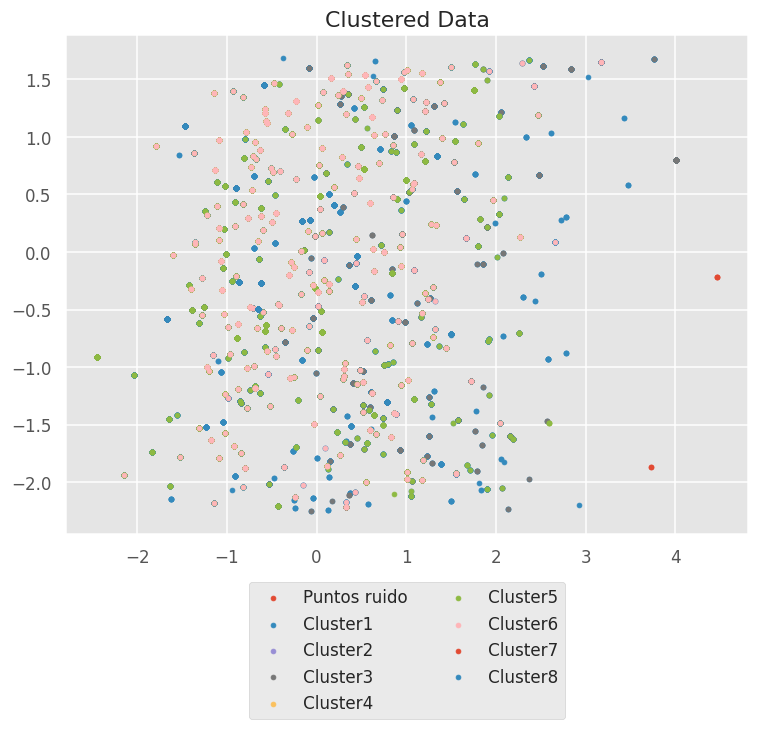

In [91]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=110)
plt.style.use('ggplot')

idx , cluster = list(zip(*clustered))
cluster = cluster[len(cluster)-len(X):]
cluster_df = pd.DataFrame(clustered, columns = ["idx", "cluster"])

for clust in np.unique(cluster):
    l_label= f'Cluster{clust}'
    if clust == 0:
        l_label = "Puntos ruido"
    plt.scatter(j[cluster_df["idx"][cluster_df["cluster"] == clust].values, 0], j[cluster_df["idx"][cluster_df["cluster"] == clust].values, 1], s=10, label=l_label)
                
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), 
       ncol=2)
plt.title('Clustered Data')
plt.show()

## Investigue sobre la mejor forma de evaluar los algoritmo K-Means y DBSCAN y documente su investigación (e incluya en el cuaderno de Jupyter a presentar al menos dos de los métodos de evaluación encontrados). Aplique uno de los métodos a la evaluación de los clusteres resultantes de los ejercicios anteriores.

El coeficiente de silueta es una medida de la cohesión y separación del grupo. Cuantifica qué tan bien encaja un punto de datos en su grupo asignado en función de dos factores:
Qué tan cerca está el punto de datos de otros puntos en el clúster
A qué distancia está el punto de datos de los puntos en otros clústeres
Los valores del coeficiente de silueta oscilan entre -1y 1. Los números más grandes indican que las muestras están más cerca de sus conglomerados que de otros conglomerados.
El coeficiente de silueta, además del método del codo,  es una buena forma de comparar los resultados de los clusters del ejercicio, ya que a estos clusters no se le conocen sus targets y esta medida está perfecta ya que no necesita saberlo. (Python, 2022)


### Evaluacion del k-means

In [53]:
from sklearn.metrics import silhouette_score
#Calculo el coeficiente de silueta
score = silhouette_score(X,cluster_2, metric='euclidean')
#Muestro el score
print(score)


0.7354770662775564


0.73 indica que las muestras están más cerca de sus conglomerados que de otros conglomerados. 

### Evaluación del DBscan

In [94]:
#Calculo el coeficiente de silueta
#En clusters_2 va os llabels :-)
score = silhouette_score(X,np.asarray(cluster), metric='euclidean')
#Muestro el score
print(score)

-0.3484712511996816


## Compare los resultados de ambos algoritmos y genere y documente sus conclusiones (incluya al menos cuatro conclusiones importantes).

1. Kmeans es mejor cuando los datos tienen muchas dimensiones, a diferencia del dbscan que conforme aumenta las dimensiones y la cantidad de datos se vuelve más ineficiente
2. Cuando los datos estan muy dispersos y los parametros del DBSCAN no se eligen bien puede resultar en un rendimiento muy deplorable como se ve en los resultados.
3. Encontramos que en nuestra implementación Kmeans es superior a DBSCAN ya que como se observa en los resultados el algoritmo kmeans muestra un coeficiente de silueta cercano a 1 indicando que las muestras están más cerca de sus conglomerados que de otros conglomerados, a diferencia del dbscan que mostró un resultado poco satisfactorio por debajo de 0.
4. Nuestra implementación de Kmeans es muy superior a DBSCAN en complejidad temporal tanto por nuestro algoritmo de Kmeans que tiene una complejidad temporal de O(n) como por la cantidad de datos, en general DBSCAN con una gran cantidad de datos tiende a crecer muy rápido en complejidad temporal.

## Referencias

- K. (2022, January 6). K-Means Clustering: Python Implementation from Scratch. Medium. https://medium.com/nerd-for-tech/k-means-python-implementation-from-scratch-8400f30b8e5c

- N. (2021, July 1). Post author: NNK. Spark by {Examples}. https://sparkbyexamples.com/pyspark/pyspark-join-explained-with-examples/#:%7E:text=PySpark%20Join%20is%20used%20to,SEMI%20%2C%20CROSS%20%2C%20SELF%20JOIN.

- How to convert string categorical variables into numerical variables using Label Encoder in python -. ProjectPro. (2022). Retrieved 8 June 2022, from https://www.projectpro.io/recipes/convert-string-categorical-variables-into-numerical-variables-using-label-encoder.

- Python, R. (2022). K-Means Clustering in Python: A Practical Guide – Real Python. Realpython.com. Retrieved 12 June 2022, from https://realpython.com/k-means-clustering-python/.

# Sección 2. PCA

## Carga de archivo, estadísticas del conjunto de datos y escalación de los atributos.

In [95]:

#Llamo al conjunto de datos previamente cargados
pandasDF = new_dataframe.toPandas()

# Estos son mis datos
# Especifico el nombre de columnas que voy a utilizar
dataframe = new_dataframe.select('porcentaje_de_población_económicamente_inactiva',
           'tasa_de_desempleo_abierto', 'relación_de_dependencia_económica',
           'Edad','cantidad_delitos_por_distrito')


#Mostrar algunas estadísticas de los datos
dataframe.describe().show()

# Convierto mis datos a un dataframe de pandas
data = dataframe.toPandas()

# media de los datos, la desviación estándar, el valor mínimo y el máximo

+-------+-----------------------------------------------+-------------------------+---------------------------------+-------------+-----------------------------+
|summary|porcentaje_de_población_económicamente_inactiva|tasa_de_desempleo_abierto|relación_de_dependencia_económica|         Edad|cantidad_delitos_por_distrito|
+-------+-----------------------------------------------+-------------------------+---------------------------------+-------------+-----------------------------+
|  count|                                          40252|                    40252|                            40252|        40252|                        40252|
|   mean|                             46.441480690805335|       3.3596249157624705|                1.486534540102139|         null|           1329.2481367385471|
| stddev|                              5.007504291127683|       0.9282857557336518|               0.3331799121028642|         null|            1683.906305084182|
|    min|                   

In [96]:
# Tomo mis targets de la columna 4
targets_nombres =  pandasDF.iloc[:,[4]]

#COnvierto a numpy mis targets
targets = targets_nombres.to_numpy()
print(targets)

[['aguabuena']
 ['aguabuena']
 ['aguabuena']
 ...
 ['zarcero']
 ['zarcero']
 ['zarcero']]


In [97]:
from sklearn import preprocessing
#Convierto de nombres a números utilizando preprocessing
le = preprocessing.LabelEncoder()
targets = le.fit_transform(targets)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [98]:
# Escalado de datos del dataframe pandas
data = df
data_zscaled = (data - data.mean()) / data.std(ddof=1)

In [99]:
# Asigno mi conjunto de datos y mis targets y los convierto a tensores
data = torch.as_tensor(data)
targets = torch.as_tensor(targets)

#Muestro cantidad de columnas y filas de cada conjunto de datos
print(data.size())
print(targets.size())

torch.Size([40252, 5])
torch.Size([40252])


## Aplíquele la técnica de PCA para reduccir la dimensionalidad del conjunto de datos.

In [100]:
from sklearn.decomposition import PCA

# Instancia del modelo con un un resultado bidimensional
pca = PCA(n_components=2)

# Aplicación a los datos
principalComponents = pca.fit_transform(data_zscaled)

# Formato
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])


In [101]:
# Se grega la columna del target
finalDf = pd.concat([principalDf, targets_nombres],axis=1)

#Se comprueba que se haya reducido la dimensionalidad a 2
print("Componentes principales PC1 y PC2")
print(finalDf)

Componentes principales PC1 y PC2
            PC1       PC2   Distrito
0     -1.437495 -0.068939  aguabuena
1     -1.437495 -0.068938  aguabuena
2     -1.437495 -0.068939  aguabuena
3     -1.437495 -0.068939  aguabuena
4     -1.437495 -0.068939  aguabuena
...         ...       ...        ...
40247 -1.452531  0.285736    zarcero
40248 -1.452527  0.291207    zarcero
40249 -1.452531  0.285736    zarcero
40250 -1.452527  0.291207    zarcero
40251 -1.452531  0.285736    zarcero

[40252 rows x 3 columns]


## Grafique la varianza explicada.

----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[0.99490205 0.00508915]


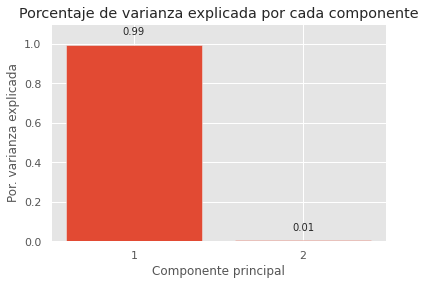

In [102]:
import numpy
modelo_pca = pca
datos = data_zscaled
# Porcentaje de varianza explicada por cada componente
# ==============================================================================
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
print(modelo_pca.explained_variance_ratio_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(modelo_pca.n_components_) + 1,
    height = modelo_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(datos.shape[1]) + 1, modelo_pca.explained_variance_ratio_):
  label = numpy.round(y, 2)
  ax.annotate(
      label,
      (x,y),
      textcoords="offset points",
      xytext=(0,10),
      ha='center'
  )

ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');

## Tres conclusiones importantes sobre el ejercicio realizado. 

- En el último gráfico, se puede observar que la varianza corresponde en torno al primer componente por lo que se puede descarter el resto si perder casi nada de datos.

- Es muy importante realizar este tipo de observaciones, como lo es la varianza explicada, para verificar si el procedimiento que se está realizando va por buen camino.

- Si todas las variables se miden en la misma escala y tienen la misma unidad, podría ser una buena idea **no** escalar las variables (es decir, PCA basado en la matriz de covarianza). Si se desea maximizar la variación, es justo dejar que las variables con más variación contribuyan más. Por otro lado, si tiene diferentes tipos de variables con diferentes unidades, probablemente sea conveniente escalar los datos primero (es decir, PCA basado en la matriz de correlación)

## Referencias

- PCA con Python. Cienciadedatos.net. (2022). Retrieved 12 June 2022, from https://www.cienciadedatos.net/documentos/py19-pca-python.html.

- Principal Component Analysis with Python - GeeksforGeeks. GeeksforGeeks. (2022). Retrieved 12 June 2022, from https://www.geeksforgeeks.org/principal-component-analysis-with-python/.

-Python para todos: Tutorial de PCA en 5 sencillos pasos. Think Big. (2022). Retrieved 12 June 2022, from https://empresas.blogthinkbig.com/python-para-todos-tutorial-de-pca-en-5/.
